# Phase 0 : Filtrage des données DVF


### Consignes

1. **Charger le fichier DVF 2022** (`.txt` avec séparateur `|`)
2. **Filtrer les lignes** correspondant à :
    - **Commune** : `LILLE` ou `BORDEAUX`
    - **Nature mutation** : `Vente`
    - **Valeur foncière** et **Surface réelle bâtie** non nulles
3. **Convertir les colonnes** `Valeur fonciere` et `Surface reelle bati` en `float` (attention au format `virgule`)
4. **Calculer le prix au m²** pour chaque bien
5. **Exporter** les deux fichiers nettoyés dans un dossier `data/`

In [2]:
import numpy as np

In [3]:
import pandas as pd
import os

# Chargement
df = pd.read_csv("../raw_data/ValeursFoncieres-2022.txt", sep='|', low_memory=False)

# Harmonisation
df['Commune'] = df['Commune'].str.upper()

# Filtrage LILLE
df_lille = df[
    (df['Commune'] == 'LILLE') &
    (df['Nature mutation'] == 'Vente') &
    (df['Surface reelle bati'].notna()) &
    (df['Valeur fonciere'].notna())
].copy()

# Filtrage BORDEAUX
df_bordeaux = df[
    (df['Commune'] == 'BORDEAUX') &
    (df['Nature mutation'] == 'Vente') &
    (df['Surface reelle bati'].notna()) &
    (df['Valeur fonciere'].notna())
].copy()

# Conversion en float
for df_city in [df_lille, df_bordeaux]:
    df_city['Valeur fonciere'] = df_city['Valeur fonciere'].astype(str).str.replace(',', '.').str.replace(' ', '').astype(float)
    df_city['Surface reelle bati'] = df_city['Surface reelle bati'].astype(str).str.replace(',', '.').str.replace(' ', '').astype(float)

# Calcul du prix au m²
df_lille['prix_m2'] = df_lille['Valeur fonciere'] / df_lille['Surface reelle bati']
df_bordeaux['prix_m2'] = df_bordeaux['Valeur fonciere'] / df_bordeaux['Surface reelle bati']

# Export
os.makedirs("../data", exist_ok=True)
df_lille.to_csv("../data/lille_2022.csv", index=False)
df_bordeaux.to_csv("../data/bordeaux_2022.csv", index=False)

print("Export terminé.")

Export terminé.


# Phase 1 — Modélisation du prix au m² à Lille (2022) pour les logements de 4 pièces

In [4]:
df_lille = pd.read_csv("../data/lille_2022.csv")

In [5]:
df_lille.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11354 entries, 0 to 11353
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Identifiant de document     0 non-null      float64
 1   Reference document          0 non-null      float64
 2   1 Articles CGI              0 non-null      float64
 3   2 Articles CGI              0 non-null      float64
 4   3 Articles CGI              0 non-null      float64
 5   4 Articles CGI              0 non-null      float64
 6   5 Articles CGI              0 non-null      float64
 7   No disposition              11354 non-null  int64  
 8   Date mutation               11354 non-null  object 
 9   Nature mutation             11354 non-null  object 
 10  Valeur fonciere             11354 non-null  float64
 11  No voie                     11248 non-null  float64
 12  B/T/Q                       652 non-null    object 
 13  Type de voie                113

In [6]:
df_lille.columns

Index(['Identifiant de document', 'Reference document', '1 Articles CGI',
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',
       'No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'prix_m2'],
      dtype='object')

In [7]:
df_lille.describe()

c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Valeur fonciere,No voie,...,4eme lot,5eme lot,Nombre de lots,Code type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture speciale,Surface terrain,prix_m2
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11354.000000,1.135400e+04,11248.000000,...,106.000000,50.000000,11354.000000,11354.000000,0.0,11354.000000,11354.000000,0.0,3672.000000,1.135400e+04
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.003963,6.906027e+05,199.709015,...,84.905660,94.180000,0.957812,2.472521,NaN,42.131760,1.323146,NaN,236.449619,inf
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062833,2.354745e+06,1072.930117,...,373.543662,346.065388,0.899357,0.789471,NaN,175.379622,1.666542,NaN,629.515964,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000e+00,1.000000,...,3.000000,7.000000,0.000000,1.000000,NaN,0.000000,0.000000,NaN,4.000000,1.347709e-04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.545000e+05,13.000000,...,7.000000,9.000000,0.000000,2.000000,NaN,0.000000,0.000000,NaN,78.000000,3.851514e+03
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.275175e+05,35.000000,...,9.000000,19.000000,1.000000,2.000000,NaN,22.000000,1.000000,NaN,124.000000,1.685750e+04
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.651500e+05,91.000000,...,31.000000,32.000000,1.000000,3.000000,NaN,59.000000,2.000000,NaN,221.000000,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,6.180000e+07,9999.000000,...,3004.000000,2256.000000,17.000000,4.000000,NaN,10945.000000,14.000000,NaN,18147.000000,inf


In [8]:
df_lille.describe(exclude= np.number)

,Date mutation,Nature mutation,B/T/Q,Type de voie,Code voie,Voie,Commune,Section,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot,Type local,Nature culture
count,11354,11354,652,11328,11354,11354,11354,11354,2442,613,75,19,16,11354,3672
unique,274,1,12,22,1041,1022,1,191,1583,296,30,6,4,4,4
top,11/08/2022,Vente,B,RUE,0657,BAYARD,LILLE,C,"319,20","326,40","328,50","326,80","273,50",Dépendance,S
freq,213,11354,475,9337,273,273,11354,481,11,11,11,11,11,4641,3467


In [9]:
df_lille['Nombre pieces principales'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11354 entries, 0 to 11353
Series name: Nombre pieces principales
Non-Null Count  Dtype  
--------------  -----  
11354 non-null  float64
dtypes: float64(1)
memory usage: 88.8 KB


In [10]:
df_lille['Nombre pieces principales'].astype('int')

0        5
1        3
2        0
3        0
4        0
        ..
11349    0
11350    0
11351    4
11352    4
11353    4
Name: Nombre pieces principales, Length: 11354, dtype: int64

## Appart & maison de 4 pieces

In [11]:
df_lille_filtered = df_lille[df_lille['Nombre pieces principales'] == 4]

In [12]:
df_lille_filtered['Type local'].unique()

array(['Maison', 'Appartement'], dtype=object)

In [13]:
df_maison = df_lille_filtered[df_lille_filtered['Type local'] == 'Maison']

In [14]:
df_appart = df_lille_filtered[df_lille_filtered['Type local'] == 'Appartement']

## 4.

In [15]:
required_columns = ['Surface reelle bati', 'Nombre pieces principales',
'Type local','Surface terrain','Nombre de lots','Valeur fonciere', 'prix_m2']

In [16]:
df_maison_ = df_maison[required_columns]

In [17]:
df_maison_.shape

(354, 7)

In [18]:
df_maison_.describe(exclude=np.number)

,Type local
count,354
unique,1
top,Maison
freq,354


In [19]:
df_maison_.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,354.000000,354.0,340.000000,354.000000,354.000000,354.000000
mean,84.310734,4.0,142.638235,0.039548,251205.864379,3003.594635
std,19.462888,0.0,84.800103,0.195171,105865.398518,1116.900260
min,44.000000,4.0,31.000000,0.000000,16000.000000,144.144144
25%,71.000000,4.0,84.750000,0.000000,185032.500000,2291.390977
50%,80.500000,4.0,127.000000,0.000000,237550.000000,2847.948718
75%,95.000000,4.0,175.250000,0.000000,290000.000000,3481.995492
max,165.000000,4.0,607.000000,1.000000,753750.000000,9192.073171


In [20]:
df_appart_ = df_appart[required_columns]

## 6. **Nettoyer les données** :
    - Supprimer les lignes avec valeurs manquantes sur les colonnes utilisées
    - Identifier et retirer les valeurs aberrantes (prix au m² trop faible ou trop élevé)

In [21]:
df_maison_.isna().any(axis=0)

Surface reelle bati          False
Nombre pieces principales    False
Type local                   False
Surface terrain               True
Nombre de lots               False
Valeur fonciere              False
prix_m2                      False
dtype: bool

In [45]:
df_maison_.dropna(axis=0, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_8588\2148659308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maison_.dropna(axis=0, inplace=True)


In [47]:
df_maison_.shape

(340, 7)

In [24]:
df_appart_.isna().any(axis=0)

Surface reelle bati          False
Nombre pieces principales    False
Type local                   False
Surface terrain               True
Nombre de lots               False
Valeur fonciere              False
prix_m2                      False
dtype: bool

In [48]:
df_appart_.dropna(axis=0,inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_8588\1012287777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_appart_.dropna(axis=0,inplace=True)


In [49]:
df_appart_.shape

(49, 7)

## Outliers

In [39]:
def drop_outliers(df:pd.DataFrame, column:str):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR=q3-q1

    without_outliers = df[((df[column]>(q1-1.5*IQR)) & (df[column]<(q3+1.5*IQR)))]
    return without_outliers
    


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

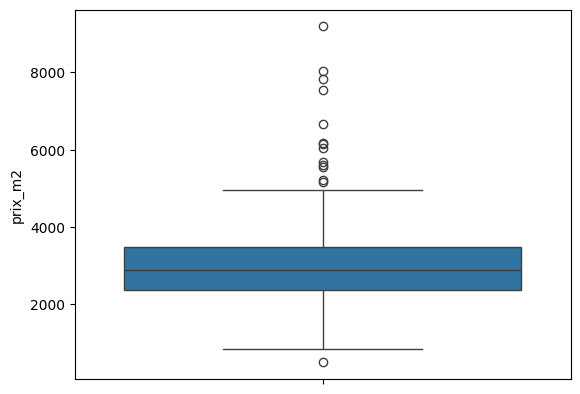

In [50]:
sns.boxplot(df_maison_['prix_m2'])
plt.show()

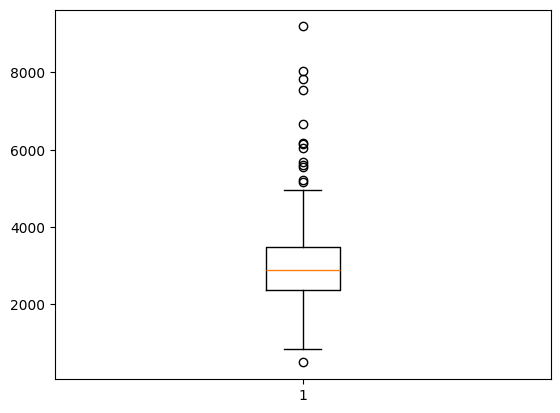

In [51]:
plt.boxplot(df_maison_['prix_m2'])
plt.show()

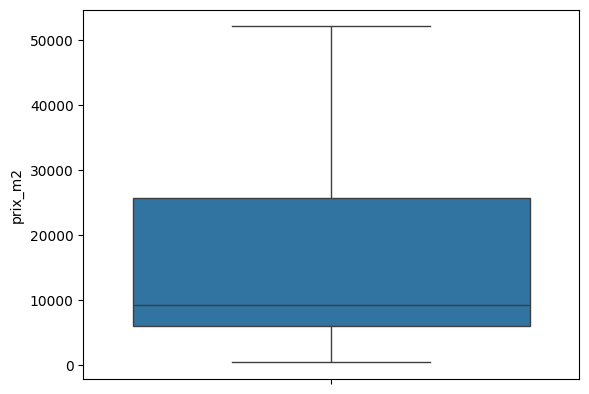

In [52]:
sns.boxplot(df_appart_['prix_m2'])
plt.show()

In [53]:
df_maison_to_process = drop_outliers(df_maison_, 'prix_m2')
df_maison_to_process.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
18,165.0,4.0,Maison,121.0,0,305000.0,1848.484848
65,64.0,4.0,Maison,127.0,0,226900.0,3545.312500
161,70.0,4.0,Maison,192.0,0,205890.0,2941.285714
168,62.0,4.0,Maison,96.0,0,159500.0,2572.580645
176,72.0,4.0,Maison,135.0,0,259900.0,3609.722222


In [54]:
df_appart_to_process = drop_outliers(df_appart_, 'prix_m2')
df_appart_to_process.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
394,116.0,4.0,Appartement,155.0,0,170000.0,1465.517241
575,170.0,4.0,Appartement,221.0,0,520000.0,3058.823529
940,53.0,4.0,Appartement,105.0,0,1470000.0,27735.849057
1249,65.0,4.0,Appartement,176.0,0,600000.0,9230.769231
1251,65.0,4.0,Appartement,176.0,0,600000.0,9230.769231


### Appart

In [55]:
df_appart_num_fea = df_appart_to_process.drop('Type local', axis=1)

In [98]:
df_appart_num_fea.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,49.000000,49.0,49.000000,49.0,4.900000e+01,49.000000
mean,85.204082,4.0,232.714286,0.0,1.509520e+06,17667.561781
std,26.742584,0.0,193.109533,0.0,1.449166e+06,15911.591246
min,18.000000,4.0,43.000000,0.0,3.000000e+04,416.666667
25%,72.000000,4.0,136.000000,0.0,4.436500e+05,6000.000000
50%,84.000000,4.0,176.000000,0.0,7.000000e+05,9230.769231
75%,94.000000,4.0,306.000000,0.0,2.155000e+06,25654.761905
max,170.000000,4.0,1207.000000,0.0,4.738000e+06,52065.934066


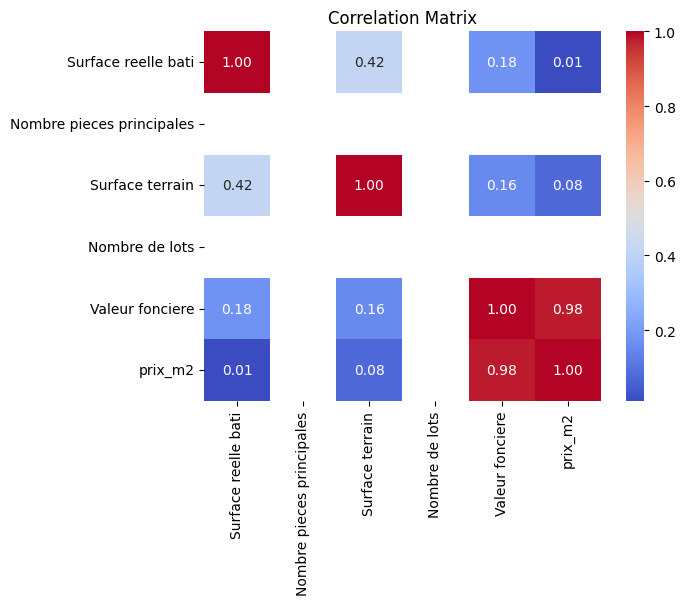

In [62]:
sns.heatmap(df_appart_num_fea.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

array([[<Axes: title={'center': 'Surface reelle bati'}>,
        <Axes: title={'center': 'Nombre pieces principales'}>],
       [<Axes: title={'center': 'Surface terrain'}>,
        <Axes: title={'center': 'Nombre de lots'}>],
       [<Axes: title={'center': 'Valeur fonciere'}>,
        <Axes: title={'center': 'prix_m2'}>]], dtype=object)

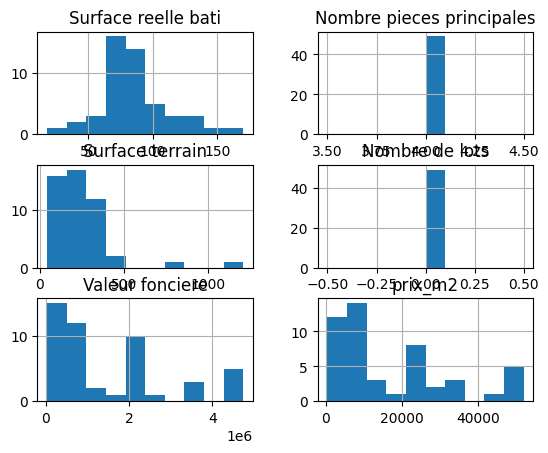

In [60]:
df_appart_num_fea.hist()

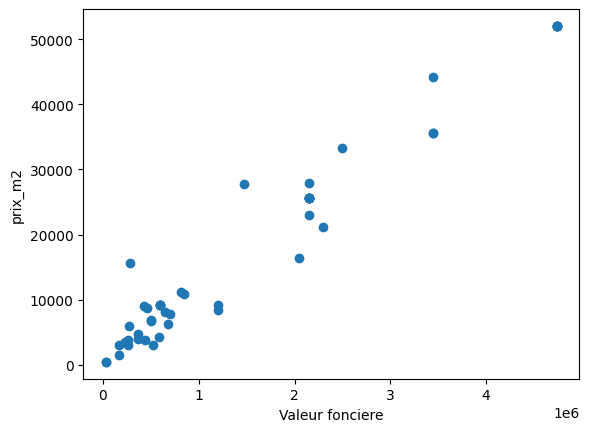

In [147]:
plt.scatter(df_appart_num_fea['Valeur fonciere'],df_appart_num_fea['prix_m2'])
plt.xlabel('Valeur fonciere')
plt.ylabel('prix_m2')
plt.show()

### Maison

In [57]:
df_maison_num_fea = df_maison_to_process.drop('Type local', axis=1)

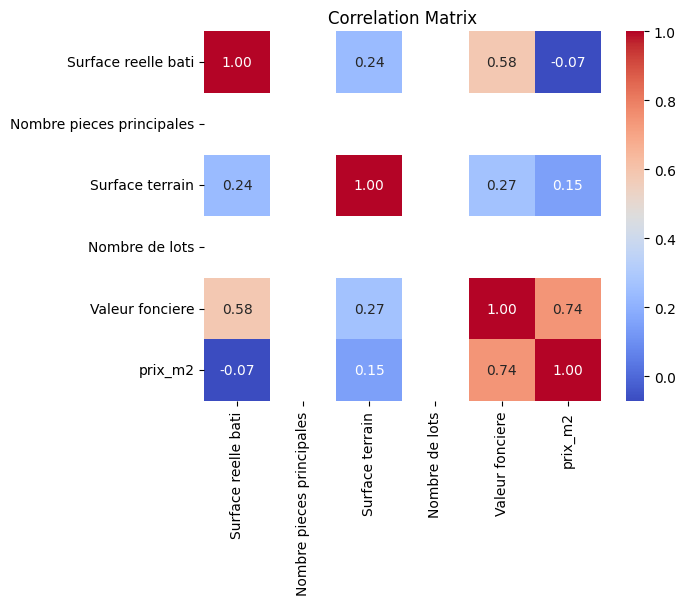

In [61]:
sns.heatmap(df_maison_num_fea.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#df_numeric = df_maison_to_process.select_dtypes(include='number')

array([[<Axes: title={'center': 'Surface reelle bati'}>,
        <Axes: title={'center': 'Nombre pieces principales'}>],
       [<Axes: title={'center': 'Surface terrain'}>,
        <Axes: title={'center': 'Nombre de lots'}>],
       [<Axes: title={'center': 'Valeur fonciere'}>,
        <Axes: title={'center': 'prix_m2'}>]], dtype=object)

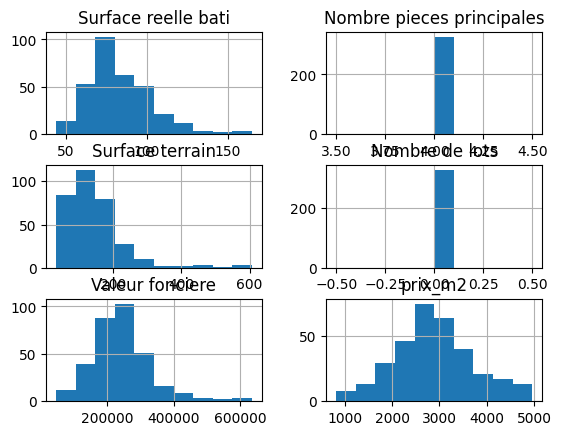

In [59]:
df_maison_num_fea.hist()

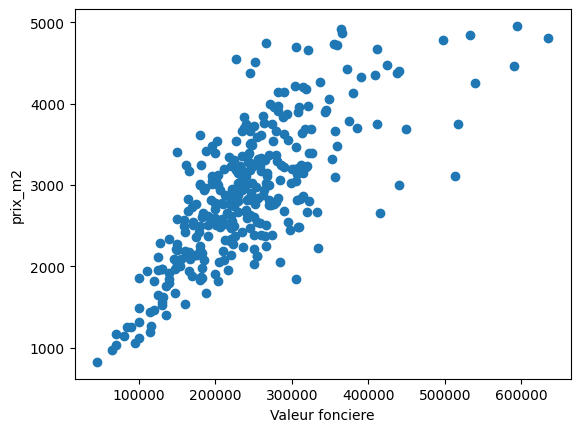

In [148]:
plt.scatter(df_maison_num_fea['Valeur fonciere'],df_maison_num_fea['prix_m2'])
plt.xlabel('Valeur fonciere')
plt.ylabel('prix_m2')
plt.show()

In [63]:
from sklearn.model_selection import train_test_split

In [99]:
from sklearn.preprocessing import StandardScaler

## 7.

### Appart

In [ ]:
# X, y calculation
X_appart = df_appart_to_process.drop(columns=['Type local','prix_m2'], axis = 1)
y_appart = df_appart_to_process[['prix_m2']]

In [ ]:
# Splitting train & test data
Xa_train,  Xa_test, ya_train, ya_test = train_test_split(X_appart,y_appart,test_size = 0.2, random_state=42)

In [ ]:
# Standardization
ScalerXa = StandardScaler()
Scalerya = StandardScaler()

In [101]:
# train data
Xa_train_scaled = ScalerXa.fit_transform(Xa_train)
ya_train_scaled = Scalerya.fit_transform(ya_train)

# test data
Xa_test_scaled = ScalerXa.transform(Xa_test)
ya_test_scaled = Scalerya.transform(ya_test)

### Maison

In [73]:
X_maison = df_maison_to_process.drop(columns=['Type local','prix_m2'], axis = 1)
y_maison = df_maison_to_process[['prix_m2']]

In [74]:
Xm_train,  Xm_test, ym_train, ym_test = train_test_split(X_maison,y_maison,test_size = 0.2, random_state=42)

In [111]:
ScalerXm = StandardScaler()
Scalerym = StandardScaler()
# train data
Xm_train_scaled = ScalerXm.fit_transform(Xm_train)
ym_train_scaled = Scalerym.fit_transform(ym_train)

# test data
Xm_test_scaled = ScalerXm.transform(Xm_test)
ym_test_scaled = Scalerym.transform(ym_test)

## 8. scikit-learn models

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [69]:
lg = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lg, dt, rf]

In [85]:
def get_pred_model(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [104]:
def eval_model(y_test, y_pred):
    return mean_squared_error(y_test,y_pred)

### Appart

In [131]:
models_metrics_appart = {}


In [132]:
pred_a = []
mse_a = []

for model in models:
    model.fit(Xa_train_scaled,ya_train_scaled)
    pred = get_pred_model(model,Xa_test_scaled)
    pred_a.append(pred)
    mse = eval_model(ya_test_scaled, pred)
    mse_a.append(mse)
    name_model = model.__class__.__name__
    models_metrics_appart[name_model] = (model,mse)

mse_a

c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.010178002899222202, 0.011862539074223882, 0.0572281255897414]

In [133]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.010178002899222202),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.011862539074223882),
 'RandomForestRegressor': (RandomForestRegressor(), 0.0572281255897414)}

### Maison

In [134]:
models_metrics_maison = {}

In [135]:
pred_m = []
mse_m = []
for model in models:
    model.fit(Xm_train_scaled,ym_train_scaled)
    pred = get_pred_model(model,Xm_test_scaled)
    pred_m.append(pred)
    mse = eval_model(ym_test_scaled, pred)
    mse_m.append(mse)
    name_model = model.__class__.__name__
    models_metrics_maison[name_model] = (model,mse)

mse_m


c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.03551937839484864, 0.07175301737644824, 0.05174824631807942]

In [136]:
models_metrics_maison


{'LinearRegression': (LinearRegression(), 0.03551937839484864),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.07175301737644824),
 'RandomForestRegressor': (RandomForestRegressor(), 0.05174824631807942)}

## 9. GridSearchCV

In [115]:
from sklearn.model_selection import GridSearchCV

### Appart

In [137]:
# Optimiser Decision Tree avec GridSearchCV
dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(Xa_train_scaled, ya_train_scaled)
best_dt = grid_dt.best_estimator_

##"Decision Tree Optimisé", 
mse = eval_model(ya_test_scaled, best_dt.predict(Xa_test_scaled))


name_model = best_dt.__class__.__name__
name_model += "optimized"
models_metrics_appart[name_model] = (best_dt,mse)


# Optimiser Random Forest avec GridSearchCV
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(Xa_train_scaled, ya_train_scaled)
best_rf = grid_rf.best_estimator_

##"Random Forest Optimisé",

mse = eval_model(ya_test_scaled, best_rf.predict(Xa_test_scaled))

name_model = best_rf.__class__.__name__
name_model += "optimized"
models_metrics_appart[name_model] = (best_rf,mse)


c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [138]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.010178002899222202),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.011862539074223882),
 'RandomForestRegressor': (RandomForestRegressor(), 0.0572281255897414),
 'DecisionTreeRegressoroptimized': (DecisionTreeRegressor(max_depth=10, random_state=42),
  0.012279604167570917),
 'RandomForestRegressoroptimized': (RandomForestRegressor(max_depth=20, n_estimators=50, random_state=42),
  0.04836269641878061)}

### Maison

In [139]:
# Optimiser Decision Tree avec GridSearchCV
dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(Xm_train_scaled, ym_train_scaled)
best_dt = grid_dt.best_estimator_

##"Decision Tree Optimisé", 
mse = eval_model(ym_test_scaled, best_dt.predict(Xm_test_scaled))


name_model = best_dt.__class__.__name__
name_model += "optimized"
models_metrics_maison[name_model] = (best_dt,mse)


# Optimiser Random Forest avec GridSearchCV
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(Xm_train_scaled, ym_train_scaled)
best_rf = grid_rf.best_estimator_

##"Random Forest Optimisé",

mse = eval_model(ym_test_scaled, best_rf.predict(Xm_test_scaled))

name_model = best_rf.__class__.__name__
name_model += "optimized"
models_metrics_maison[name_model] = (best_rf,mse)


c:\Users\User\Desktop\fast-api-ml-immobilier-project\venv\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [140]:
models_metrics_maison

{'LinearRegression': (LinearRegression(), 0.03551937839484864),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.07175301737644824),
 'RandomForestRegressor': (RandomForestRegressor(), 0.05174824631807942),
 'DecisionTreeRegressoroptimized': (DecisionTreeRegressor(max_depth=10, random_state=42),
  0.07020983619978238),
 'RandomForestRegressoroptimized': (RandomForestRegressor(max_depth=10, random_state=42),
  0.05383385925090861)}

## 10. XGBRegressor

In [141]:
import xgboost as xgb

In [ ]:
# extract categorical features
#cat_features = X.select_dtypes(exclude = np.number).colimns.tolist()
#for col in cat_features:
#   X[col] = X[col].astype('category')

### Appart

In [142]:
# Create matrices
dm_train_a = xgb.DMatrix(Xa_train_scaled,ya_train_scaled)
dm_test_a = xgb.DMatrix(Xa_test_scaled,ya_test_scaled)

In [156]:
# Define hyperparameters
params = {"objective": "reg:squarederror",
          'eval_metric': 'rmse',
          "tree_method": "hist"}

n = 100
evals = [(dm_test_a, "validation"), (dm_train_a, "train")]

evals_result = {}

model = xgb.train(
   params=params,
   dtrain=dm_train_a,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   # Activate early stopping
   early_stopping_rounds=10,
   evals_result=evals_result  # ← clé pour récupérer les métriques
)



[0]	validation-rmse:0.68671	train-rmse:0.74790
[10]	validation-rmse:0.12892	train-rmse:0.05176
[20]	validation-rmse:0.11723	train-rmse:0.00565
[30]	validation-rmse:0.11521	train-rmse:0.00098
[40]	validation-rmse:0.11510	train-rmse:0.00064
[50]	validation-rmse:0.11510	train-rmse:0.00064
[60]	validation-rmse:0.11510	train-rmse:0.00064
[62]	validation-rmse:0.11510	train-rmse:0.00064


In [157]:
rmse_list = evals_result["validation"]["rmse"]
best_rmse = rmse_list[model.best_iteration]
best_mse = best_rmse ** 2
print(f"Best RMSE: {best_rmse}")
print(f"Best MSE: {best_mse}")

Best RMSE: 0.11510444141541598
Best MSE: 0.013249032433554929


In [152]:
ypred= model.predict(dm_test_a)
mse=mean_squared_error(ya_test_scaled,ypred)

In [153]:
mse

0.013249051049923752

In [158]:
model_name = model.__class__.__name__
model_name

'Booster'

#### en utilisant l’API scikit-learn de XGBoost

In [160]:
from xgboost import XGBRegressor

model_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',
    n_estimators=100, early_stopping_rounds=10
)


model_regressor.fit(Xa_train_scaled, ya_train_scaled, eval_set=[(Xa_test_scaled,ya_test_scaled)])
ypred_regressor = model_regressor.predict(Xa_test_scaled)
mse_regressor = mean_squared_error(ya_test_scaled,ypred_regressor)
mse_regressor

[0]	validation_0-rmse:0.68671
[1]	validation_0-rmse:0.53364
[2]	validation_0-rmse:0.42606
[3]	validation_0-rmse:0.32158


[4]	validation_0-rmse:0.25798
[5]	validation_0-rmse:0.21169
[6]	validation_0-rmse:0.17864
[7]	validation_0-rmse:0.15763
[8]	validation_0-rmse:0.14380
[9]	validation_0-rmse:0.13402
[10]	validation_0-rmse:0.12892
[11]	validation_0-rmse:0.12556
[12]	validation_0-rmse:0.12406
[13]	validation_0-rmse:0.12322
[14]	validation_0-rmse:0.12179
[15]	validation_0-rmse:0.12041
[16]	validation_0-rmse:0.11944
[17]	validation_0-rmse:0.11821
[18]	validation_0-rmse:0.11792
[19]	validation_0-rmse:0.11765
[20]	validation_0-rmse:0.11723
[21]	validation_0-rmse:0.11706
[22]	validation_0-rmse:0.11690
[23]	validation_0-rmse:0.11643
[24]	validation_0-rmse:0.11607
[25]	validation_0-rmse:0.11580
[26]	validation_0-rmse:0.11560
[27]	validation_0-rmse:0.11543
[28]	validation_0-rmse:0.11532
[29]	validation_0-rmse:0.11523
[30]	validation_0-rmse:0.11521
[31]	validation_0-rmse:0.11520
[32]	validation_0-rmse:0.11516
[33]	validation_0-rmse:0.11513
[34]	validation_0-rmse:0.11513
[35]	validation_0-rmse:0.11513
[36]	validatio

0.013246392779545679

In [161]:
model_name = model_regressor.__class__.__name__
model_name

'XGBRegressor'

In [162]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.010178002899222202),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.011862539074223882),
 'RandomForestRegressor': (RandomForestRegressor(), 0.0572281255897414),
 'DecisionTreeRegressoroptimized': (DecisionTreeRegressor(max_depth=10, random_state=42),
  0.012279604167570917),
 'RandomForestRegressoroptimized': (RandomForestRegressor(max_depth=20, n_estimators=50, random_state=42),
  0.04836269641878061)}

In [163]:
models_metrics_appart[model_name]=(model_regressor,mse_regressor)

In [164]:
models_metrics_appart

{'LinearRegression': (LinearRegression(), 0.010178002899222202),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.011862539074223882),
 'RandomForestRegressor': (RandomForestRegressor(), 0.0572281255897414),
 'DecisionTreeRegressoroptimized': (DecisionTreeRegressor(max_depth=10, random_state=42),
  0.012279604167570917),
 'RandomForestRegressoroptimized': (RandomForestRegressor(max_depth=20, n_estimators=50, random_state=42),
  0.04836269641878061),
 'XGBRegressor': (XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=10,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=Non

## Maison 

In [165]:
from xgboost import XGBRegressor

model_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',
    n_estimators=100, early_stopping_rounds=10
)


model_regressor.fit(Xm_train_scaled, ym_train_scaled, eval_set=[(Xm_test_scaled,ym_test_scaled)])
ypred_regressor = model_regressor.predict(Xm_test_scaled)
mse_regressor = mean_squared_error(ym_test_scaled,ypred_regressor)
mse_regressor
model_name = model_regressor.__class__.__name__
model_name
models_metrics_maison[model_name]=(model_regressor,mse_regressor)
models_metrics_maison

[0]	validation_0-rmse:0.72189
[1]	validation_0-rmse:0.56211
[2]	validation_0-rmse:0.45116
[3]	validation_0-rmse:0.37451
[4]	validation_0-rmse:0.31851
[5]	validation_0-rmse:0.27675
[6]	validation_0-rmse:0.24566
[7]	validation_0-rmse:0.22010
[8]	validation_0-rmse:0.21162
[9]	validation_0-rmse:0.19982
[10]	validation_0-rmse:0.19161
[11]	validation_0-rmse:0.18703
[12]	validation_0-rmse:0.18337
[13]	validation_0-rmse:0.17847
[14]	validation_0-rmse:0.17763
[15]	validation_0-rmse:0.17674
[16]	validation_0-rmse:0.17645
[17]	validation_0-rmse:0.17620
[18]	validation_0-rmse:0.17446
[19]	validation_0-rmse:0.17344
[20]	validation_0-rmse:0.17325
[21]	validation_0-rmse:0.17244
[22]	validation_0-rmse:0.17100
[23]	validation_0-rmse:0.17143
[24]	validation_0-rmse:0.17141
[25]	validation_0-rmse:0.17182
[26]	validation_0-rmse:0.17177
[27]	validation_0-rmse:0.17158
[28]	validation_0-rmse:0.17123
[29]	validation_0-rmse:0.17098
[30]	validation_0-rmse:0.17091
[31]	validation_0-rmse:0.17090
[32]	validation_0-

{'LinearRegression': (LinearRegression(), 0.03551937839484864),
 'DecisionTreeRegressor': (DecisionTreeRegressor(), 0.07175301737644824),
 'RandomForestRegressor': (RandomForestRegressor(), 0.05174824631807942),
 'DecisionTreeRegressoroptimized': (DecisionTreeRegressor(max_depth=10, random_state=42),
  0.07020983619978238),
 'RandomForestRegressoroptimized': (RandomForestRegressor(max_depth=10, random_state=42),
  0.05383385925090861),
 'XGBRegressor': (XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=10,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=N

<class 'float'> 1
LinearRegression
<class 'float'> 0.010178002899222202
<class 'float'> 0.010178002899222202
<class 'float'> 0.010178002899222202
<class 'float'> 0.010178002899222202
<class 'float'> 0.010178002899222202


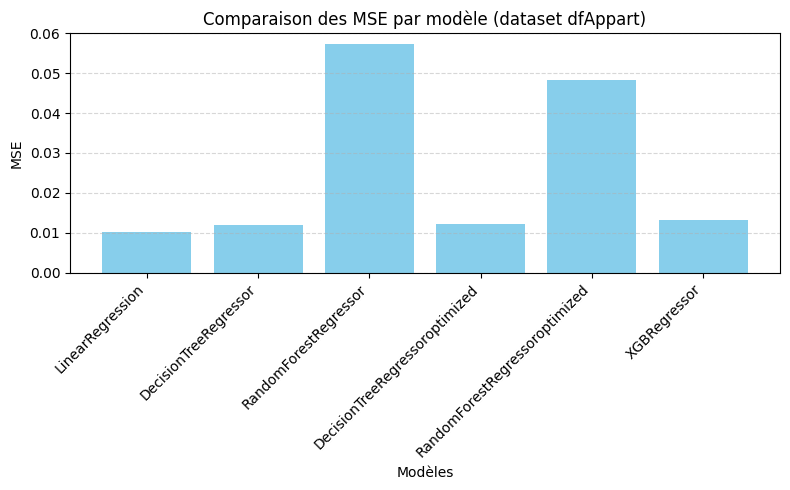

In [186]:
min_mse = 1
best_model = ""
mse_list=[]
for key in models_metrics_appart.keys():
    print(type(models_metrics_appart[key][1]), min_mse)
    mse_list.append(models_metrics_appart[key][1])
    msek = models_metrics_appart[key][1]
    if msek < min_mse:
        print(key)
        min_mse = models_metrics_appart[key][1]
        best_model_a = key


labels = list(models_metrics_appart.keys())
x = range(len(labels))  # positions numériques

plt.figure(figsize=(8, 5))
plt.bar(x, mse_list, color='skyblue')
plt.title("Comparaison des MSE par modèle (dataset dfAppart)")
plt.ylabel("MSE")
plt.xlabel("Modèles")
plt.xticks(x, labels, rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [187]:
min_mse = 1
best_model = ""
mse_list=[]
for key in models_metrics_maison.keys():
    print(type(models_metrics_maison[key][1]), min_mse)
    mse_list.append(models_metrics_maison[key][1])
    msek = models_metrics_maison[key][1]
    if msek < min_mse:
        print(key)
        min_mse = models_metrics_maison[key][1]
        best_model_m = key 

<class 'float'> 1
LinearRegression
<class 'float'> 0.03551937839484864
<class 'float'> 0.03551937839484864
<class 'float'> 0.03551937839484864
<class 'float'> 0.03551937839484864
<class 'float'> 0.03551937839484864
XGBRegressor


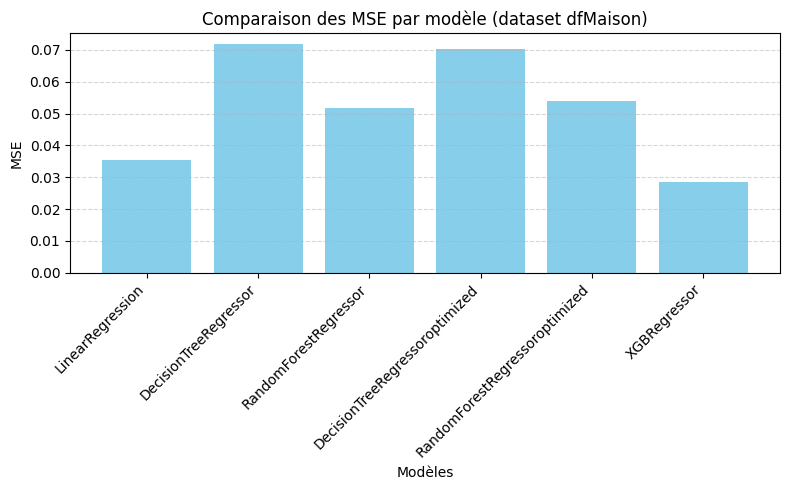

In [188]:

labels = list(models_metrics_maison.keys())
x = range(len(labels))  # positions numériques

plt.figure(figsize=(8, 5))
plt.bar(x, mse_list, color='skyblue')
plt.title("Comparaison des MSE par modèle (dataset dfMaison)")
plt.ylabel("MSE")
plt.xlabel("Modèles")
plt.xticks(x, labels, rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [190]:
best_model_a

'LinearRegression'

In [ ]:

best_model_m

'XGBRegressor'

In [184]:
Xa_train_scaled.shape

(39, 5)

In [185]:
Xm_train_scaled.shape

(260, 5)

# Save models

In [130]:
import joblib

In [191]:
# Save model and scaler
joblib.dump({'model_a': models_metrics_appart[best_model_a][0], 
             'scaler_Xa': ScalerXa, 
             'scaler_ya':Scalerya,
             'model_m': models_metrics_maison[best_model_m][0], 
             'scaler_Xm': ScalerXm, 
             'scaler_ym':Scalerym}, 
            'models/model_lille.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_lille.pkl'